In [1]:
# import required packages
import pandas as pd
import math
import sklearn.metrics
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import numpy as np
import xgboost as xgb
from category_encoders.target_encoder import TargetEncoder


In [2]:
train_df = pd.read_csv('train_data.csv', parse_dates= ['startdate']) 
test_df = pd.read_csv('test_data.csv',  parse_dates= ['startdate']) 

In [3]:
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [4]:
test_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,375734,0.0,0.833333,2022-11-01,339.88,30.88,30.92,29.17,31.02,29.47,...,-19.28,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27
1,375735,0.0,0.833333,2022-11-02,334.63,30.88,30.92,29.17,31.02,29.47,...,-19.58,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16
2,375736,0.0,0.833333,2022-11-03,337.83,30.88,30.92,29.17,31.02,29.47,...,-13.73,-44.22,-27.67,49.76,-1.31,21.44,-19.06,26.85,-16.78,13.42
3,375737,0.0,0.833333,2022-11-04,345.81,30.88,30.92,29.17,31.02,29.47,...,-7.97,-49.47,-19.32,52.62,-0.44,21.65,-23.12,23.70,-18.62,10.69
4,375738,0.0,0.833333,2022-11-05,357.39,30.88,30.92,29.17,31.02,29.47,...,-0.80,-56.07,-9.89,51.23,-7.57,19.86,-30.56,20.66,-25.08,19.64


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31354 entries, 0 to 31353
Columns: 245 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(241), int64(2), object(1)
memory usage: 58.6+ MB


In [7]:
train_df.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744064,10.801682,12.726739,10.099323,11.638229,10.733886,11.772646,...,-1.209959,-8.109918,6.800684,19.251970,-17.697565,-9.846867,-6.231860,16.014364,10.489945,11.296334
std,108465.207359,0.251744,0.272059,198.085182,10.952417,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201507,38.458878,25.288526,31.946748,34.164678,27.050356,25.847455,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.560000,-13.720000,-13.330000,...,-94.570000,-89.940000,-64.870000,-39.280000,-100.560000,-106.080000,-93.980000,-52.610000,-66.110000,-57.610000
25%,93933.250000,0.409091,0.300000,104.062500,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200000,-33.350000,-19.650000,1.960000,-40.030000,-32.170000,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320000,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.050000,-16.710000,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010000,20.230000,22.110000,18.740000,20.360000,18.330000,20.300000,...,24.940000,17.960000,28.660000,35.090000,4.390000,10.500000,11.630000,31.210000,29.040000,29.180000
max,375733.000000,1.000000,1.000000,1185.140000,36.080000,36.030000,33.390000,34.640000,35.750000,38.350000,...,113.920000,96.550000,106.420000,91.760000,56.550000,83.890000,64.850000,90.390000,76.890000,88.660000


In [8]:
test_df.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,...,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000
mean,391410.500000,0.592766,0.517964,299.244395,19.363234,21.195801,19.204389,20.140415,18.261659,20.396613,...,22.030820,-34.379016,25.485902,36.913279,-21.290328,10.448689,-12.676885,8.211967,-11.478033,21.083770
std,9051.264507,0.251748,0.272063,117.029504,7.310349,7.151861,7.146665,6.169318,5.539982,7.087798,...,30.914333,24.479350,30.720523,17.083142,22.336810,8.557387,29.438632,29.897845,18.660838,16.841297
min,375734.000000,0.000000,0.000000,32.820000,1.550000,2.900000,1.170000,3.530000,1.840000,0.080000,...,-19.900000,-76.450000,-29.250000,6.500000,-59.540000,-5.450000,-66.770000,-32.150000,-53.690000,-16.560000
25%,383572.250000,0.409091,0.300000,215.962500,14.060000,16.140000,14.440000,15.840000,14.660000,15.540000,...,2.220000,-56.070000,3.630000,19.570000,-39.340000,4.720000,-30.630000,-18.360000,-23.150000,13.420000
50%,391410.500000,0.590909,0.533333,292.915000,19.940000,21.720000,19.325000,20.150000,18.210000,20.340000,...,14.700000,-31.070000,22.740000,37.090000,-21.420000,10.660000,-22.640000,0.150000,-13.950000,21.090000
75%,399248.750000,0.818182,0.766667,371.330000,24.610000,26.810000,24.760000,24.890000,22.180000,25.730000,...,34.300000,-15.510000,44.690000,49.660000,-0.790000,17.090000,14.420000,28.840000,-0.470000,32.410000
max,407087.000000,1.000000,1.000000,740.170000,36.080000,36.030000,32.970000,33.910000,35.310000,37.420000,...,116.770000,25.330000,79.610000,71.270000,14.150000,29.000000,33.350000,74.130000,28.270000,51.450000


In [9]:
# Check for NaN values in the dataframe
nan_cols_train = train_df.isna().any()

# Count the number of NaN values in each column that contains NaN values
nan_count_train = train_df.isna().sum()[nan_cols_train]

print(nan_count_train)

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64


In [10]:
nan_cols_test = test_df.isna().any()

# Count the number of NaN values in each column that contains NaN values
nan_count_test = test_df.isna().sum()[nan_cols_test]

print(nan_count_test)

Series([], dtype: int64)


In [11]:
nan_cols_list = nan_count_train.index.tolist()
nan_cols_list

['nmme0-tmp2m-34w__ccsm30',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-prate-34w__ccsm3',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-34w__ccsm30',
 'nmme-prate-56w__ccsm3',
 'nmme-tmp2m-34w__ccsm3',
 'ccsm30']

In [12]:
# fill tmp columns' nans with the value of the column nmme-tmp2m-34w__cfsv2 as it has the best rmse (from a calculation done further below)
# for prate columns just use the mean of the column

tmp_columns = ['nmme0-tmp2m-34w__ccsm30', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-34w__ccsm3', 'ccsm30']
prate_columns = ['nmme-prate-34w__ccsm3','nmme0-prate-56w__ccsm30','nmme0-prate-34w__ccsm30','nmme-prate-56w__ccsm3']

for column in train_df.columns:
    if column in tmp_columns:
        train_df[column] = train_df[column].fillna(value=train_df['nmme-tmp2m-34w__cfsv2'])
    if column in prate_columns:
        # calculate the mean value of the column
        mean_value = train_df[column].mean()

        # fill missing values with the mean
        train_df[column].fillna(value=mean_value, inplace=True)

In [13]:
# Let's check that there are no nans left

# Check for NaN values in the dataframe
nan_cols_train = train_df.isna().any()

# Count the number of NaN values in each column that contains NaN values
nan_count_train = train_df.isna().sum()[nan_cols_train]

print(nan_count_train)

Series([], dtype: int64)


In [14]:
# renaming some more frequently used columns 

train_df = train_df.rename(columns={'climateregions__climateregion': 'region', 'contest-tmp2m-14d__tmp2m': 'target_tmp'})
test_df = test_df.rename(columns={'climateregions__climateregion': 'region', 'contest-tmp2m-14d__tmp2m': 'target_tmp'})

#### Merge lon and lat

If we merge the lon and lat columns we get each unique region

In [15]:
# clean up lon and lat based on Kaggle notebook: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved#Solution

scale = 14

train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

In [16]:
# Select the columns to merge
columns_to_merge = ['lon', 'lat']

# create a new column with the merged values
train_df['lon_lat'] = train_df[columns_to_merge]\
    .apply(lambda x: '_'.join(x.astype(str)), axis=1)

test_df['lon_lat'] = test_df[columns_to_merge]\
    .apply(lambda x: '_'.join(x.astype(str)), axis=1)

In [17]:
# check how many unique values each column has

unique_counts_df = pd.DataFrame(train_df.apply(lambda x: x.nunique()), columns=['Unique Values']).T
unique_counts_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,lon_lat
Unique Values,375734,23,31,731,74166,4029,4046,3947,3983,3667,...,711,702,705,713,701,707,700,705,707,514


#### Calculate moving averages for daily features

In [18]:
# # change daily values to a moving average calculated the same way as target_tmp (avg of min and max value over 14 days)

# daily_measures_list = train_df.filter(regex='mjo1d__amplitude|^sst|^wind').columns.tolist()


# def create_moving_averages(df):
#     for column in df.columns:
#         if column in daily_measures_list:
#             new_col_name = column+'_avg_14d'
#             # calculate the rolling average for 14 days, NOTE: how to do min max instead?
#             df[new_col_name] = df.groupby('region')[column].transform(lambda x: x.rolling(14, 1).mean())
#     df.drop(daily_measures_list, axis=1, inplace=True)        

# create_moving_averages(train_df)
# create_moving_averages(test_df)


In [19]:
# train_df['lon_lat'].unique().tolist()[0:15]

In [20]:
# example_df = train_df[(train_df['startdate']< '2015-10-01') & ((train_df['lon_lat']== '0.83333333333333_0.0') | (train_df['lon_lat']== '0.83333333333333_0.04545454545455'))]

# example_df = example_df[['startdate','lon_lat', 'wind-vwnd-925-2010-11_avg_14d']]

# example_df.tail(50)

In [21]:
# forecasts_34_56_list = train_df.filter(regex='34|56').columns.tolist()
# forecasts_34_56_list

### EDA

The following graphs will be created to get a better understanding of the data:

* The average target_tmp for each region over time
* The variance in temperature per region on a specific date
* Each temperature forecast vs target temperature

In [22]:
# Group the dataframe by the 'region' and 'startdate' columns
avg_tmp_df = train_df.groupby(['region', 'startdate'])['target_tmp'].mean().reset_index()

# Rename the columns
avg_tmp_df = avg_tmp_df.rename(columns={'target_tmp':'avg_tmp'})

avg_tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10965 entries, 0 to 10964
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   region     10965 non-null  object        
 1   startdate  10965 non-null  datetime64[ns]
 2   avg_tmp    10965 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 257.1+ KB


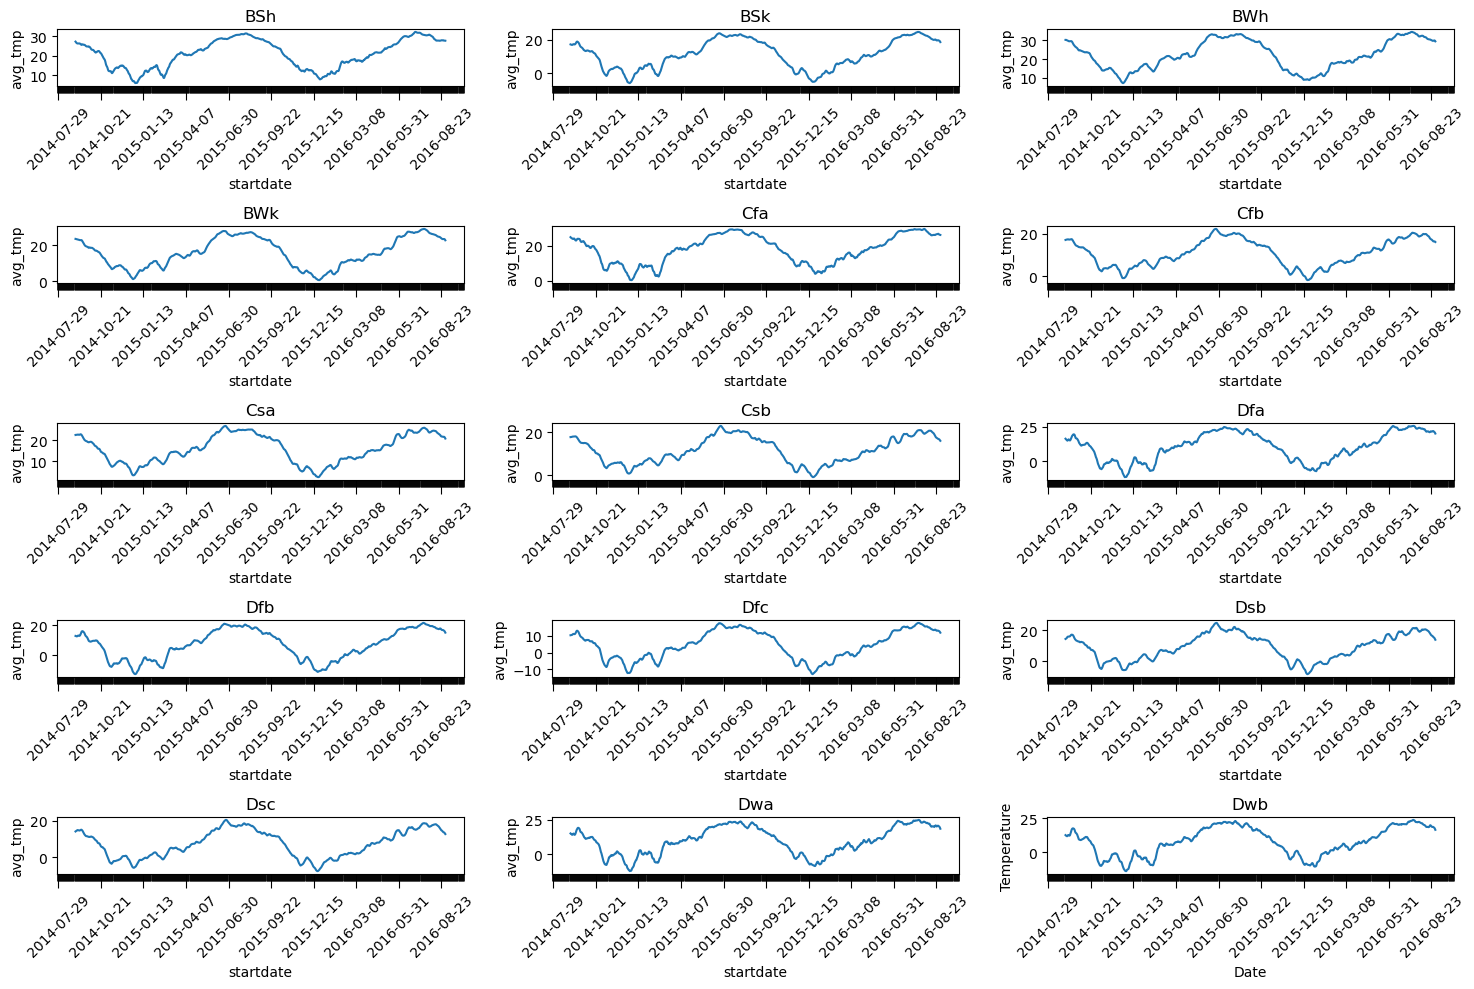

In [23]:
# prepare the figure
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))

# set the regions
regions = avg_tmp_df['region'].unique()

# iterate through the regions
for i, region in enumerate(regions):
    ax = axs[i//3, i%3]
    data = avg_tmp_df[avg_tmp_df['region'] == region]
    sns.lineplot(ax = ax, x='startdate', y='avg_tmp', data=data)
    ax.set_title(region)
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1, interval = 12))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)
    ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))
    ax.tick_params(axis = 'x', which = 'major', length = 10)
    ax.tick_params(axis = 'x', which = 'minor', length = 5)
    plt.xlabel('Date')
    plt.ylabel('Temperature')

# adjust the layout
fig.tight_layout()

# display the plot
plt.show()

#### Checking how much the temperature varies within each location of a region

In [24]:
# group the dataframe by the 'region' column
grouped = train_df.groupby('region')

# calculate the mean and standard deviation for the 'average_tmp' column for each group (region)
mean_temp = grouped['target_tmp'].mean()
std_temp = grouped['target_tmp'].std()

# print the results
print("Mean Temperature by Region: \n", mean_temp)
print("Standard deviation Temperature by Region: \n", std_temp)

Mean Temperature by Region: 
 region
BSh    20.883240
BSk    11.103087
BWh    22.196044
BWk    15.865922
Cfa    17.906166
Cfb    10.832186
Csa    15.686419
Csb    11.523091
Dfa    10.494672
Dfb     6.893599
Dfc     4.406667
Dsb     9.038471
Dsc     7.344342
Dwa     9.741287
Dwb     8.012755
Name: target_tmp, dtype: float64
Standard deviation Temperature by Region: 
 region
BSh     7.470302
BSk     9.402671
BWh     8.223290
BWk     8.835503
Cfa     8.746388
Cfb     6.725490
Csa     7.581058
Csb     6.978523
Dfa    10.326161
Dfb     9.957170
Dfc     8.756981
Dsb     8.506871
Dsc     7.895506
Dwa     9.900792
Dwb    10.209946
Name: target_tmp, dtype: float64


In [25]:
agg_temp = train_df.groupby(['region', 'startdate'])['target_tmp']\
                .agg(Mean='mean', Std='std', Count='count')\
                .sort_values('Std', ascending = False).reset_index()

agg_temp.head(10)

,region,startdate,Mean,Std,Count
0,Csa,2014-11-08,8.570182,7.635407,13
1,Csa,2014-11-09,8.289784,7.538632,13
2,Csa,2014-11-10,7.875758,7.518483,13
3,Csa,2014-11-07,8.987362,7.510783,13
4,Dfb,2015-02-06,-3.435579,7.497692,72
5,Dfb,2015-02-01,-3.593637,7.466386,72
6,Dfb,2015-02-09,-5.412851,7.428983,72
7,Dfb,2015-02-02,-3.111648,7.409277,72
8,Dfb,2015-02-05,-3.327157,7.386860,72
9,Dfb,2015-02-08,-4.411949,7.367470,72


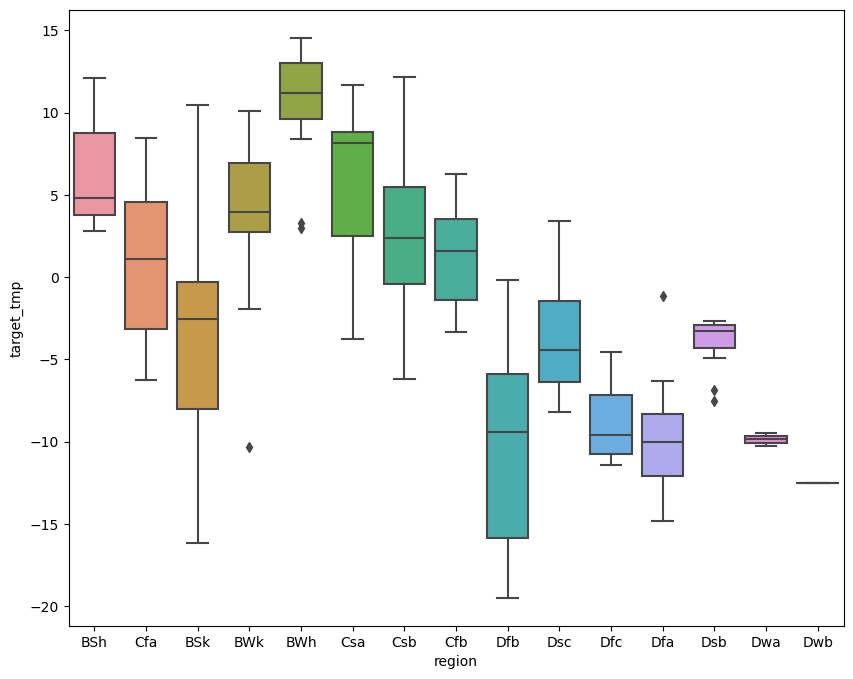

In [26]:
# for the 01/01/2015, how much did temperature differe per region?

specific_date_df = train_df[train_df['startdate'] == '2015-01-01']

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x="region", y="target_tmp", data=specific_date_df, ax=ax)
plt.show()

#### Display each temperature forecasts together with the target_tmp, to see how well the forecasts do

In [27]:
# subset df to only contain nmme columns, startdate, lon_lat and target for visualisation
df_filtered = train_df.filter(regex='^nmme-tmp|^nmme0-tmp|^target|^startdate|^lon_lat')
df_filtered.head()

,startdate,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,...,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,lon_lat
0,2014-09-01,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,0.83333333333333_0.0
1,2014-09-02,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,0.83333333333333_0.0
2,2014-09-03,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,0.83333333333333_0.0
3,2014-09-04,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,0.83333333333333_0.0
4,2014-09-05,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17,0.83333333333333_0.0


In [28]:
# choose a small date range and a specific region

df_example = df_filtered[(df_filtered['startdate']< '2015-10-01') & (df_filtered['lon_lat']== '0.83333333333333_0.0')]
del df_example['lon_lat']
df_example.head()


,startdate,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,...,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean
0,2014-09-01,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.83,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17
1,2014-09-02,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.83,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17
2,2014-09-03,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.83,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17
3,2014-09-04,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.83,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17
4,2014-09-05,29.02,31.64,29.57,30.73,29.71,31.52,31.68,30.56,29.66,...,27.83,29.34,27.57,27.98,27.3,28.27,28.42,28.3,28.55,28.17


In [29]:
# # plot the forecasts vs target_tmp

# df_example.set_index('startdate', inplace=True)


# # Loop through the temperature forecasting columns
# for column in df_example.columns:
#     if column != 'target_tmp':
#         # Create a line plot of the current temperature column and target_tmp
#         df_example[[column, 'target_tmp']].plot(kind='line')

#         # Add a title and labels for the x and y axis
#         plt.title(f'Temperature comparison ({column} vs target_tmp)')
#         plt.xlabel('Date')
#         plt.ylabel('Temperature (°C)')

#         # Show the plot
#         plt.show()

### calculate rmse for forcasts

To check how well the various forecasts do, let's calculate their rmse 

In [30]:
df_filtered = train_df.filter(regex='^nmme-tmp|^nmme0-tmp|nmme0$|^target|^cancm30|^cancm40|^ccsm30|^ccsm40|^cfsv20')

actual = df_filtered['target_tmp']

for column in df_filtered.columns:
    if column != 'target_tmp':
        temp_df = df_filtered[column]
        mean_value= df_filtered[column].mean()
        temp_df.fillna(value=mean_value, inplace=True)
        predicted = temp_df
        mse = sklearn.metrics.mean_squared_error(actual, predicted)
        rmse = math.sqrt(mse)
        print(column,': ','\n', rmse, '\n')

nmme0-tmp2m-34w__cancm30 :  
 6.17670203375041 

nmme0-tmp2m-34w__cancm40 :  
 6.27330488743956 

nmme0-tmp2m-34w__ccsm30 :  
 5.79151698797448 

nmme0-tmp2m-34w__ccsm40 :  
 6.020552566244839 

nmme0-tmp2m-34w__cfsv20 :  
 5.200209294360366 

nmme0-tmp2m-34w__gfdlflora0 :  
 5.7060386485106775 

nmme0-tmp2m-34w__gfdlflorb0 :  
 5.709360309625786 

nmme0-tmp2m-34w__gfdl0 :  
 6.181147980225957 

nmme0-tmp2m-34w__nasa0 :  
 6.152152038245845 

nmme0-tmp2m-34w__nmme0mean :  
 5.633671046326305 

nmme-tmp2m-56w__cancm3 :  
 4.449405977690274 

nmme-tmp2m-56w__cancm4 :  
 4.4287741550038495 

nmme-tmp2m-56w__ccsm3 :  
 4.685923776369252 

nmme-tmp2m-56w__ccsm4 :  
 3.605571790391836 

nmme-tmp2m-56w__cfsv2 :  
 3.271164184864818 

nmme-tmp2m-56w__gfdl :  
 3.894275294913568 

nmme-tmp2m-56w__gfdlflora :  
 3.4935069363826656 

nmme-tmp2m-56w__gfdlflorb :  
 3.4804188267516625 

nmme-tmp2m-56w__nasa :  
 4.5890912230563865 

nmme-tmp2m-56w__nmmemean :  
 3.446414655790314 

nmme-tmp2m-34w__

In [31]:
# create a df which does not contain the forecasts and certain columns which don't seem to be useful
# when comparing train vs test distributions

forecast_models_col_list = train_df.filter(regex='^nmme|^cancm|^ccsm|cfsv20|nasa0|gfdlflora0|gfdlflorb0|gfdl0|^icec')\
                         .columns.tolist()

#leave only one model in the data (the one with the lowest rmse from above) and the most relevant prate model
forecast_models_col_list.remove('nmme0mean')
forecast_models_col_list.remove('nmme0-prate-56w__cancm30')
forecast_models_col_list

train_df = train_df.drop(forecast_models_col_list, axis=1)
test_df = test_df.drop(forecast_models_col_list, axis=1)


### Creating dataframes for the same type of columns to implement correlation matrices

In [32]:
def filter_df(df, string):
    filtered_df = df.filter(regex=f'^{string}|^target_tmp')
    return filtered_df


In [33]:
icec_df = filter_df(train_df, "icec")
icec_df.head()

,target_tmp
0,28.744480
1,28.370585
2,28.133059
3,28.256798
4,28.372353


In [34]:
# nmme_prate_df = filter_df(train_df, "nmme-prate")
# nmme0_prate_df = filter_df(train_df, "nmme0-prate")
# nmme_tmp_df = filter_df(train_df, "nmme-tmp")
# nmme0_tmp_df = filter_df(train_df, "nmme0-tmp")
# sst_df = filter_df(train_df, "sst")
# wind_hgt_10_df = filter_df(train_df, "wind-hgt-10-")
# wind_hgt_850_df = filter_df(train_df, "wind-hgt-850-")
# wind_uwnd_250_df = filter_df(train_df, "wind-uwnd-250")
# wind_vwnd_250_df = filter_df(train_df, "wind-vwnd-250")

In [35]:
def create_corr_matrix(df): 

    # Compute the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 210, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr,cmap=cmap, annot=True, vmin=-1, vmax=1, center=0)

    plt.show()

In [36]:
# create_corr_matrix(icec_df)

In [37]:
# create_corr_matrix(nmme_prate_df)

In [38]:
# create_corr_matrix(nmme0_prate_df)

In [39]:
# create_corr_matrix(nmme_tmp_df)

In [40]:
# create_corr_matrix(nmme0_tmp_df)

In [41]:
# create_corr_matrix(sst_df)

In [42]:
# create_corr_matrix(wind_hgt_850_df)

In [43]:
# create_corr_matrix(wind_uwnd_250_df)

In [44]:
# create_corr_matrix(wind_vwnd_250_df)

## XGBoost 

#### Feature engineering

* Create time features
* Make them cyclical where necesarry

In [45]:
# Resource: https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=p8piDWNxFq0H

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    
    # encode the day with a period of 365
    df['day_sin'] = sin_transformer(365).fit_transform(df['startdate'].dt.day)
    df['day_cos'] = cos_transformer(365).fit_transform(df['startdate'].dt.day)

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['startdate'].dt.isocalendar().week)
    df['week_cos'] = cos_transformer(52).fit_transform(df['startdate'].dt.isocalendar().week)

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['startdate'].dt.month)
    df['month_cos'] = cos_transformer(12).fit_transform(df['startdate'].dt.month)
    
    # year does not need encoding
    df['year'] = df['startdate'].dt.year 

In [46]:
encode_cyclical(train_df)
encode_cyclical(test_df)
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,target_tmp,...,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,lon_lat,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year
0,0,0.0,0.833333,2014-09-01,237.00,31246.63,81.72,16666.81,17.41,28.744480,...,11.90,4.58,0.83333333333333_0.0,0.017213,0.999852,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
1,1,0.0,0.833333,2014-09-02,228.90,31244.78,82.56,16667.31,17.41,28.370585,...,15.44,3.42,0.83333333333333_0.0,0.034422,0.999407,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
2,2,0.0,0.833333,2014-09-03,220.69,31239.27,83.29,16668.39,17.41,28.133059,...,15.11,4.82,0.83333333333333_0.0,0.051620,0.998667,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
3,3,0.0,0.833333,2014-09-04,225.28,31232.86,83.26,16667.39,17.41,28.256798,...,18.24,9.74,0.83333333333333_0.0,0.068802,0.997630,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
4,4,0.0,0.833333,2014-09-05,237.24,31226.16,82.50,16665.65,17.41,28.372353,...,21.91,10.95,0.83333333333333_0.0,0.085965,0.996298,-0.935016,-0.354605,-1.0,-1.836970e-16,2014


### Encode categorical variables

#### One-hot-encoding

In [47]:
# # encode categorical variables so that they can be used by the model

# train_df_onehot = no_fc_df.copy()
# train_df_onehot = pd.get_dummies(train_df_onehot, columns=['year', 'month', 'week','day', 'region', 'lon_lat'])

# #drop columns we don't need anymore
# train_df_onehot = train_df_onehot.drop(['lon', 'lat'], axis=1)

# train_df_onehot.head()

#### Target encoding

In [48]:
# set up the encoder
encoder = TargetEncoder(cols=['region', 'lon_lat'], smoothing = 10)

# fit the encoder - finds the mean target value per category
train_df_no_target = train_df.drop(['target_tmp'], axis=1)
encoder.fit(train_df_no_target, train_df['target_tmp'])

# transform data
encoded_df_train = encoder.transform(train_df_no_target)
encoded_df_test = encoder.transform(test_df)

encoded_df_train.drop(['index', 'lat', 'lon'], axis=1, inplace=True)
encoded_df_test.drop(['index','lat', 'lon'], axis=1, inplace=True)

encoded_df_train = pd.concat([encoded_df_train,train_df['target_tmp']], axis=1)
encoded_df_train.head()
# encoded_df_test.head()

,startdate,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,...,wind-vwnd-925-2010-20,lon_lat,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year,target_tmp
0,2014-09-01,237.00,31246.63,81.72,16666.81,17.41,101352.08,4.41,98644.97,-2.56,...,4.58,23.474873,0.017213,0.999852,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.744480
1,2014-09-02,228.90,31244.78,82.56,16667.31,17.41,101396.02,3.74,98686.80,-2.39,...,3.42,23.474873,0.034422,0.999407,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.370585
2,2014-09-03,220.69,31239.27,83.29,16668.39,17.41,101429.25,3.40,98712.85,-2.76,...,4.82,23.474873,0.051620,0.998667,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.133059
3,2014-09-04,225.28,31232.86,83.26,16667.39,17.41,101440.85,3.29,98711.70,-3.00,...,9.74,23.474873,0.068802,0.997630,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.256798
4,2014-09-05,237.24,31226.16,82.50,16665.65,17.41,101419.53,3.27,98686.46,-3.40,...,10.95,23.474873,0.085965,0.996298,-0.935016,-0.354605,-1.0,-1.836970e-16,2014,28.372353


#### Perform PCA for dimensionality reduction

In [49]:
# startdate_df = encoded_df_train[['startdate', 'target_tmp']]
# startdate_df.head()

In [50]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import numpy as np

In [51]:
# #define scaler
# scaler = StandardScaler()

# #create copy of DataFrame
# scaled_df = encoded_df_train.copy()
# # scaled_df = scaled_df.drop(['year', 'month', 'week', 'day', 'region', 'lon_lat', 'startdate', 'lon', 'lat', 'target_tmp'], axis=1)
# scaled_df = scaled_df.drop(['startdate'], axis=1)
# pca_columns = list(scaled_df.columns.values)

# #created scaled version of DataFrame
# scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
# scaled_df.head()

In [52]:
# scaled_df.shape

In [53]:
# #define PCA model to use
# pca = PCA(n_components=50)

# #fit PCA model to data
# pca_fit = pca.fit(scaled_df)


In [54]:
# pc_values = np.arange(pca.n_components_) + 1
# plt.plot(pc_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.show() 

In [55]:
# plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
# plt.grid()
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Explained Variance')
# sns.despine();

In [56]:
# # transform the original dataset to the reduced dataset
# reduced_df = pca_fit.transform(scaled_df)
# reduced_df = pd.DataFrame(reduced_df)
# reduced_df.shape

In [57]:
# # merge the reduced dataframe with the startdate

# train_df_onehot_reduced = encoded_df_train.drop(pca_columns, axis=1)
# train_df_onehot_reduced.head()
# train_df_onehot_reduced.shape

In [58]:
# merged_df = pd.concat([reduced_df, startdate_df], axis=1)
# merged_df.shape

In [59]:
train = encoded_df_train.loc[encoded_df_train['startdate'] < '2016-07-01' ]
validation = encoded_df_train.loc[encoded_df_train['startdate'] >= '2016-07-01' ]

In [60]:
train = train.drop(['startdate'], axis=1)
len(train)

343866

In [61]:
validation = validation.drop(['startdate'], axis=1)
len(validation)

31868

In [62]:
no_target = train.drop(['target_tmp'], axis=1)
no_target.head()

,contest-pevpr-sfc-gauss-14d__pevpr,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-prwtr-eatm-14d__prwtr,...,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,lon_lat,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,year
0,237.00,31246.63,81.72,16666.81,17.41,101352.08,4.41,98644.97,-2.56,42.45,...,11.90,4.58,23.474873,0.017213,0.999852,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
1,228.90,31244.78,82.56,16667.31,17.41,101396.02,3.74,98686.80,-2.39,42.66,...,15.44,3.42,23.474873,0.034422,0.999407,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
2,220.69,31239.27,83.29,16668.39,17.41,101429.25,3.40,98712.85,-2.76,43.23,...,15.11,4.82,23.474873,0.051620,0.998667,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
3,225.28,31232.86,83.26,16667.39,17.41,101440.85,3.29,98711.70,-3.00,43.11,...,18.24,9.74,23.474873,0.068802,0.997630,-0.935016,-0.354605,-1.0,-1.836970e-16,2014
4,237.24,31226.16,82.50,16665.65,17.41,101419.53,3.27,98686.46,-3.40,42.98,...,21.91,10.95,23.474873,0.085965,0.996298,-0.935016,-0.354605,-1.0,-1.836970e-16,2014


In [63]:
#Get the list of all column names from headers
features = list(no_target.columns.values)
target = 'target_tmp'


In [64]:
X_train = train[features]
y_train = train[target]

X_val = validation[features]
y_val = validation[target]

In [65]:
# data_drift_list = encoded_df_train.filter(regex='^mei|^sst|^wind|contest-pevpr-sfc-gauss-14d__pevpr')\
#                          .columns.tolist()

# X_train_2 = X_train[data_drift_list]
# X_val_2 = X_val[data_drift_list]

In [110]:
# data_drift_list

In [67]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from numpy import absolute

In [68]:
# X = train_df_onehot[features]
# y = train_df_onehot[target]

In [69]:
# # why did it have an extra index column?

# X.drop(columns=['index'], inplace=True)
# X.head()

In [70]:
# y.head()

In [71]:
# model = xgb.XGBRegressor(n_estimators=100, learning_rate = 0.1, max_depth = 5, gamma = 1, subsample = 0.5)
# # define model evaluation method
# cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
# # evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose = 1)
# # force scores to be positive
# scores = absolute(scores)
# print('RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [72]:
# # BEST model so far, with rmse of 0.90139 after 1000 rounds (n_estimators = 1000), next try with 10000)

# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 30, learning_rate = 0.02, max_depth = 5, gamma = 1, subsample = 0.5) 
# reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = True)

In [73]:
# Try next

# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 30, learning_rate = 0.02, max_depth = 5, gamma = 1) 
# reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = True)

In [74]:
# # average rmse: 0.95

# from datetime import datetime, timedelta

# exclude_cols = ['startdate']
# features = [c for c in encoded_df_train.columns if ((c != target) & (c not in exclude_cols))]
# target = 'target_tmp'

# N_FOLDS = 5

# for fold in range(N_FOLDS):
#     training_date = encoded_df_train['startdate'].max() - timedelta(14) * (N_FOLDS-fold)
#     valid_date = training_date + timedelta(14)
#     print(f"\nFold {fold}: \ntraining data from {encoded_df_train['startdate'].min()} to {training_date}\nvalidation data from {training_date + timedelta(1)} to {valid_date}")
#     train = encoded_df_train[encoded_df_train['startdate'] <= training_date]
#     val  = encoded_df_train[(encoded_df_train['startdate'] > training_date) & (encoded_df_train['startdate'] <= valid_date) ]
    
#     X_train = train[features]
#     y_train = train[target]

#     X_val = val[features]
#     y_val = val[target]
    
#     reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.05, max_depth = 8, gamma = 1, early_stopping_rounds = 30, seed=30) 
#     reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 1)


In [75]:
# exclude_cols = ['startdate']
# features = [c for c in encoded_df_train.columns if ((c != target) & (c not in exclude_cols))]
# target = 'target_tmp'

# X_train = encoded_df_train[features]
# y_train = encoded_df_train[target]

# model = xgb.XGBRegressor(n_estimators=2000, learning_rate = 0.05, max_depth = 6, gamma = 1, seed=30) 
# model.fit(X_train, y_train)


In [76]:
# with n_estimators=1000, learning_rate = 0.1, max_depth = 6, gamma = 1, RMSE = 0.97 (forgot to put seed with this)

# training the model
# model = xgb.XGBRegressor(n_estimators=500, learning_rate = 0.08, max_depth = 6, seed=30, early_stopping_rounds = 100, gamma=1) 
# model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = True)


In [77]:
# model_2 = xgb.XGBRegressor(n_estimators=100, learning_rate = 0.1, max_depth = 6, seed=30, early_stopping_rounds = 100, gamma=1) 
# model_2.fit(X_train_2, y_train, eval_set = [(X_train_2, y_train), (X_val_2, y_val)], verbose = True)

In [78]:
# from xgboost import plot_importance

# # plot feature importance
# plot_importance(model, max_num_features = 30)
# plt.show()

In [79]:
# # from xgboost import plot_importance

# # plot feature importance
# plot_importance(model_2, max_num_features = 30)
# plt.show()

In [80]:
# fig, ax = plt.subplots()
# sns.kdeplot(data=train_df['contest-pevpr-sfc-gauss-14d__pevpr'],  color='blue', fill=True, ax=ax)
# sns.kdeplot(data=test_df['contest-pevpr-sfc-gauss-14d__pevpr'], color='orange', fill=True, ax=ax)
# plt.show()

In [81]:
# # loading the sample submission file
# submission = pd.read_csv('sample_solution.csv')
# submission.head()

In [82]:
# # #making predictions and replacing the values of the sample file
# target_variable = 'contest-tmp2m-14d__tmp2m'
# submission[target_variable] = model.predict(encoded_df_test[features])

In [83]:
# #making predictions and replacing the values of the sample file
# # target_variable = 'contest-tmp2m-14d__tmp2m'
# submission['model_2'] = model_2.predict(encoded_df_test[data_drift_list])

In [84]:
# submission[target_variable]= submission['model_1'] * 0.9 + submission['model_2'] * 0.1

In [85]:
# submission.drop(['model_1', 'model_2'], axis=1, inplace = True)

In [86]:
# submission.tail(20)

In [87]:
# #save the submission file
# submission.to_csv('submission.csv', index = False) 

### Catboost

In [88]:
# import catboost
# print(catboost.__version__)

In [89]:
# from catboost import CatBoostRegressor, Pool

In [90]:
# cb = CatBoostRegressor(n_estimators=500, learning_rate = 0.1, max_depth = 6, early_stopping_rounds = 100, loss_function='RMSE', verbose = True)

# pool_train = Pool(X_train, y_train, cat_features = ['region', 'lon_lat'])

# pool_val = Pool(X_val, cat_features = ['region', 'lon_lat'])

# pool_test = Pool(test_df, cat_features = ['region', 'lon_lat'])

# cb.fit(pool_train, eval_set = [(X_train, y_train), (X_val, y_val)])
# y_pred = cb.predict(pool_val)

# model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)])


In [91]:
# # loading the sample submission file
# submission = pd.read_csv('sample_solution.csv')
# submission.head()

In [92]:
# #making predictions and replacing the values of the sample file
# target_variable = 'contest-tmp2m-14d__tmp2m'
# submission[target_variable] = cb.predict(pool_test)

In [93]:
# submission.tail(20)

In [94]:
# #save the submission file
# submission.to_csv('submission.csv', index = False) 

In [95]:
# bla = test_df[features].columns.tolist()
# bla

In [96]:
X_train_lgbm = X_train.drop(['week_sin', 'week_cos'], axis=1)
X_val_lgbm = X_val.drop(['week_sin', 'week_cos'], axis=1)

In [97]:
from lightgbm import LGBMRegressor, plot_importance 

In [98]:
lgbm = LGBMRegressor(n_estimators=5000, learning_rate = 0.05, max_depth = 6, seed=30, early_stopping_rounds = 100, loss_function='RMSE')
lgbm.fit(X_train_lgbm, y_train, eval_set = [(X_train_lgbm, y_train), (X_val_lgbm, y_val)], verbose = True)


[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	training's l2: 84.719	valid_1's l2: 142.985
Training until validation scores don't improve for 100 rounds
[2]	training's l2: 77.2791	valid_1's l2: 130.889
[3]	training's l2: 70.4971	valid_1's l2: 119.666
[4]	training's l2: 64.3725	valid_1's l2: 108.809
[5]	training's l2: 58.8098	valid_1's l2: 99.1454
[6]	training's l2: 53.7913	valid_1's l2: 92.36
[7]	training's l2: 49.2098	valid_1's l2: 84.215
[8]	training's l2: 45.0452	valid_1's l2: 77.1017
[9]	training's l2: 41.2606	valid_1's l2: 70.7834
[10]	training's l2: 37.8182	valid_1's l2: 64.8474
[11]	training's l2: 34.6868	valid_1's l2: 59.4942
[12]	training's l2: 31.8724	valid_1's l2: 54.4127
[13]	training's l2: 29.2894	valid_1's l2: 50.1062
[14]	training's l2: 26.9297	valid_1's l2: 47.1881
[15]	training's l2: 24.7943	valid_1's l2: 43.225
[16]	traini

LGBMRegressor(early_stopping_rounds=100, learning_rate=0.05,
              loss_function='RMSE', max_depth=6, n_estimators=5000, seed=30)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

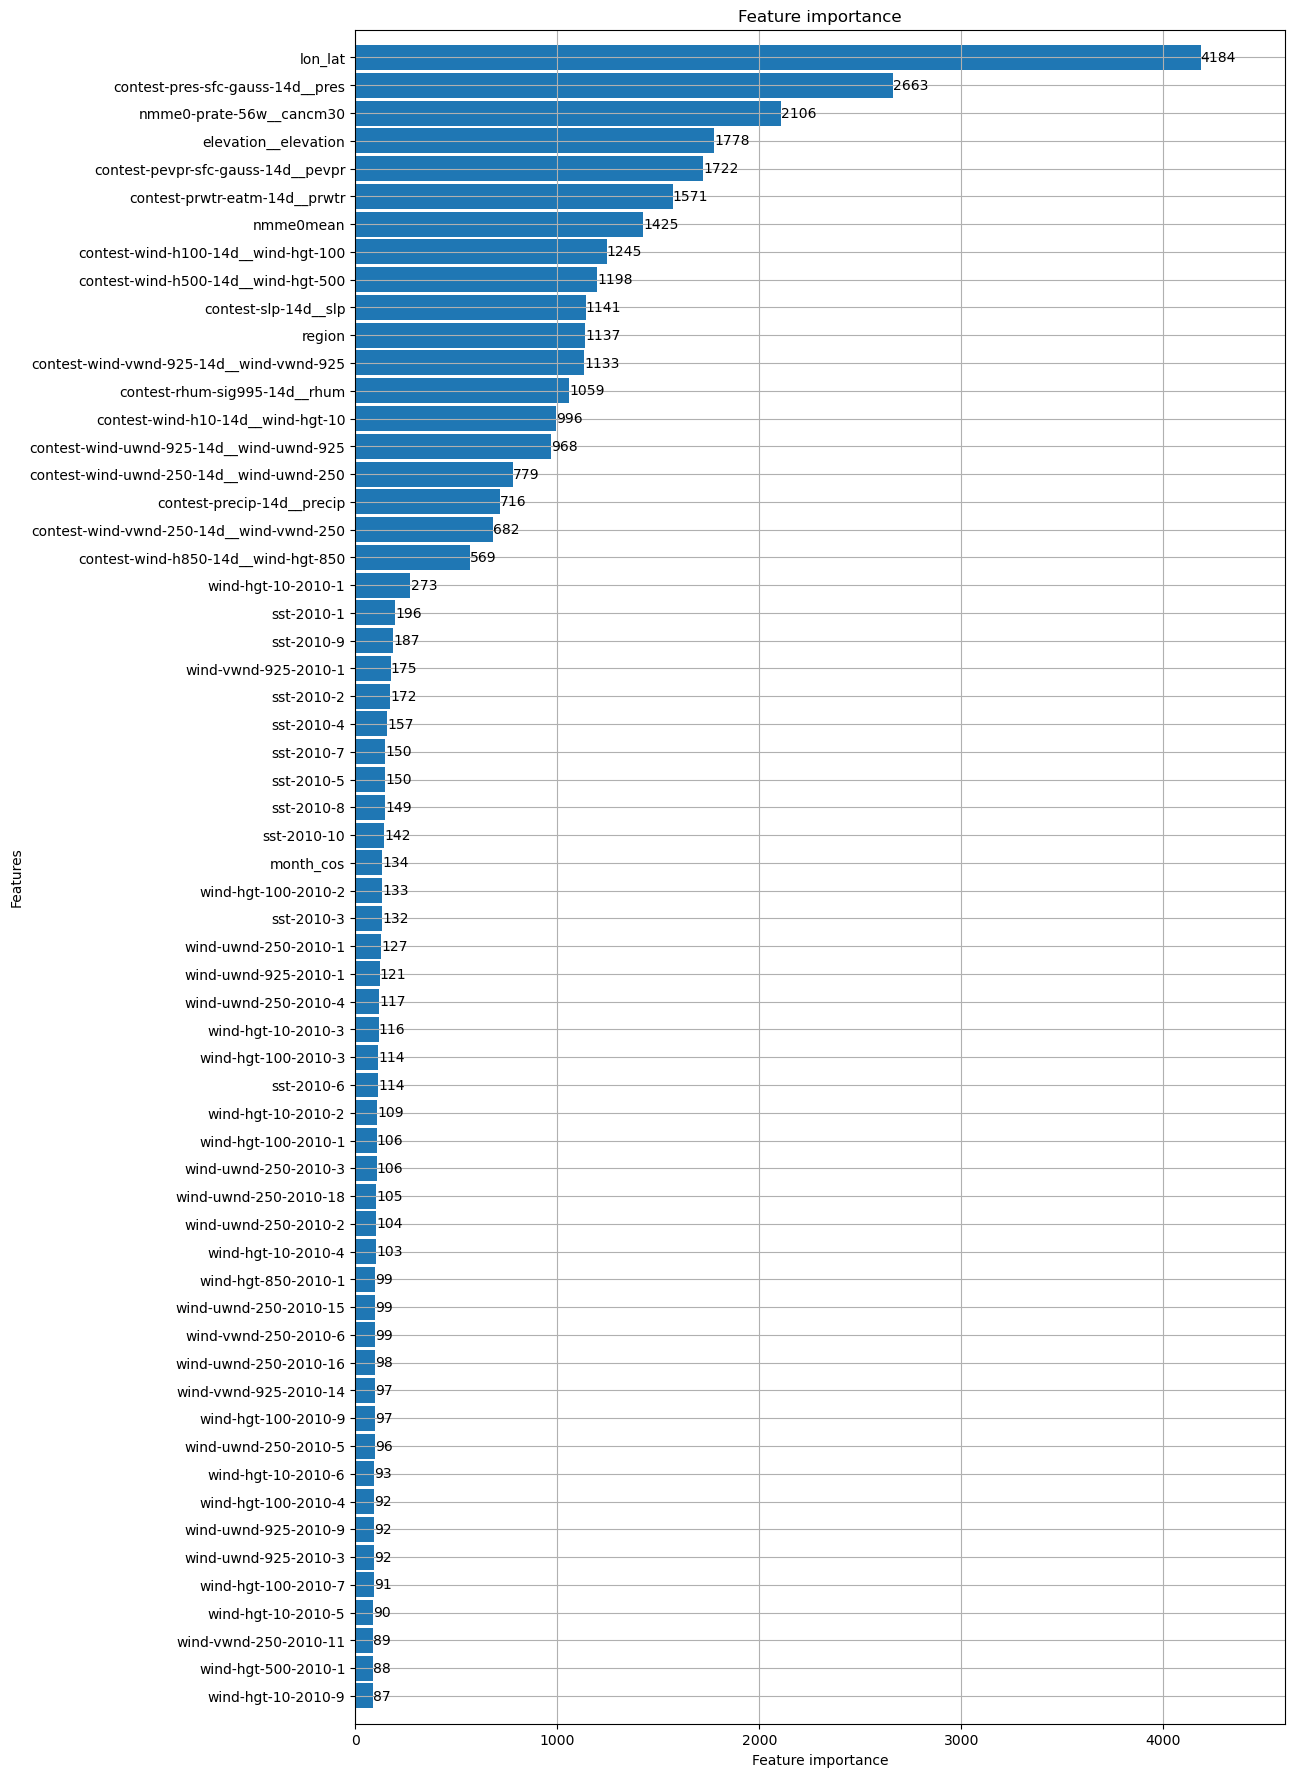

In [99]:
import lightgbm

plt.rcParams["figure.figsize"] = (12, 22)

lightgbm.plot_importance(lgbm, max_num_features = 60, height=.9)

In [105]:
# loading the sample submission file
submission = pd.read_csv('sample_solution.csv')
submission.head()

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738


In [106]:
test = encoded_df_test[features].drop(['week_sin', 'week_cos'], axis=1)

In [107]:
# #making predictions and replacing the values of the sample file
target_variable = 'contest-tmp2m-14d__tmp2m'
submission[target_variable] = lgbm.predict(test)

In [108]:
submission.tail(20)

,contest-tmp2m-14d__tmp2m,index
31334,5.942775,407068
31335,6.207120,407069
31336,6.144424,407070
31337,6.756147,407071
31338,5.940955,407072
31339,5.115514,407073
31340,5.033058,407074
31341,5.434904,407075
31342,5.328213,407076
31343,5.868469,407077


In [109]:
#save the submission file
submission.to_csv('submission.csv', index = False) 